# Imports

In [ ]:
# Using Python
import zipfile
import os

zip_path = '/content/candlestick_patterns2.zip'
extract_path = '/content/candlestick_patterns2'  # folder to extract files

# Create folder if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to {extract_path}")


Files extracted to /content/candlestick_patterns2


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
import os
import random
import shutil

# Data Augmentation

In [ ]:
# Original dataset path (already limited to 200 per class)
limited_dataset_path = '/content/candlestick_patterns2/limited_dataset'

# Paths for split
split_base = '/content/candlestick_patterns2/split_dataset'
train_path = os.path.join(split_base, 'train')
val_path = os.path.join(split_base, 'val')
test_path = os.path.join(split_base, 'test')

for path in [train_path, val_path, test_path]:
    os.makedirs(path, exist_ok=True)

# Split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

for class_name in os.listdir(limited_dataset_path):
    class_folder = os.path.join(limited_dataset_path, class_name)
    images = os.listdir(class_folder)
    random.shuffle(images)

    n_total = len(images)
    n_train = int(n_total * train_ratio)
    n_val = int(n_total * val_ratio)
    n_test = n_total - n_train - n_val  # remaining

    # Paths for this class
    train_class = os.path.join(train_path, class_name)
    val_class = os.path.join(val_path, class_name)
    test_class = os.path.join(test_path, class_name)

    for p in [train_class, val_class, test_class]:
        os.makedirs(p, exist_ok=True)

    # Copy images
    for img in images[:n_train]:
        shutil.copy(os.path.join(class_folder, img), train_class)
    for img in images[n_train:n_train+n_val]:
        shutil.copy(os.path.join(class_folder, img), val_class)
    for img in images[n_train+n_val:]:
        shutil.copy(os.path.join(class_folder, img), test_class)

print("Train, validation, and test datasets created!")



Train, validation, and test datasets created!


In [ ]:
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    shear_range=0.1,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generators
train_gen = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    val_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_directory(
    test_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # important for evaluation
)

print("Classes:", train_gen.class_indices)


Found 640 images belonging to 4 classes.
Found 80 images belonging to 4 classes.
Found 80 images belonging to 4 classes.
Classes: {'bearish_engulfing1': 0, 'bullish_engulfing1': 1, 'double_top': 2, 'shooting_star1': 3}


# Model And Training

In [ ]:
class_labels = ['bearish_engulfing1', 'bullish_engulfing1', 'dounle_top', 'shooting_sta1'] # Define class_labels here
num_classes = len(class_labels)

# Load MobileNetV2 without top layer, pretrained on ImageNet
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze base layers initially
base_model.trainable = False

# Custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=2,
    restore_best_weights=True,
    min_delta=0.001
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=0.0001
)

# Fit the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=8,
    batch_size=batch_size, # Use the defined batch_size variable
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.3089 - loss: 1.6482 - val_accuracy: 0.5375 - val_loss: 1.0353 - learning_rate: 1.0000e-04
Epoch 2/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.3931 - loss: 1.3309 - val_accuracy: 0.6875 - val_loss: 0.8469 - learning_rate: 1.0000e-04
Epoch 3/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.5005 - loss: 1.1083 - val_accuracy: 0.7000 - val_loss: 0.7894 - learning_rate: 1.0000e-04
Epoch 4/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.5594 - loss: 0.9566 - val_accuracy: 0.7625 - val_loss: 0.7037 - learning_rate: 1.0000e-04
Epoch 5/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.5660 - loss: 0.9449 - val_accuracy: 0.7375 - val_loss: 0.6847 - learning_rate: 1.0000e-04
Epoch 6/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.6214 - loss: 0.8576 - val_accuracy: 0.8375 - val_loss: 0.6299 - learning_rate: 1.0000e-04
Epoch 7/8
20/20 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.6952 - loss: 0.8175

In [ ]:
model.save("5_layer_candlestick.h5")

In [ ]:
model = tf.keras.models.load_model("5_layer_candlestick_optimized.h5")

class_labels = ['bearish_engulfing', 'bullish_engulfing', 'double_top', 'shooting_star']

# Evaluate Graph

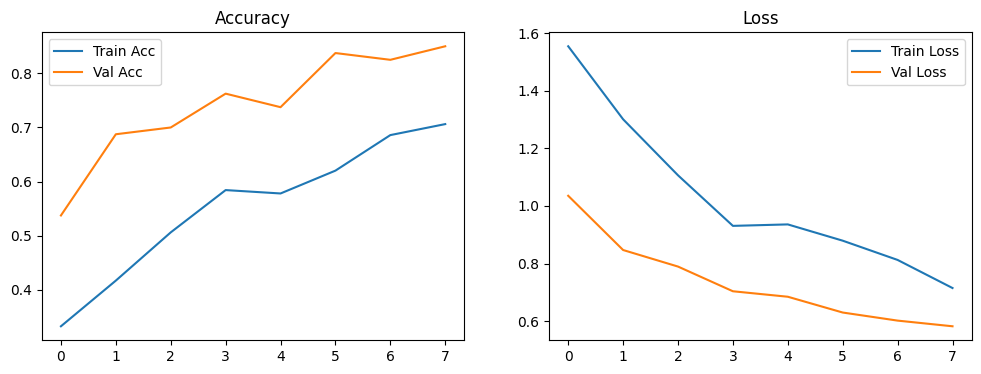

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss')
plt.show()


# Classify and testing

In [ ]:
# Class names from your training generator
class_labels = list(train_gen.class_indices.keys())

def predict_pattern(img_path, actual_label=None):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = class_labels[np.argmax(predictions)]
    confidence = np.max(predictions) * 100

    # Show image and result
    plt.imshow(image.load_img(img_path))
    plt.axis("off")
    title = f"Predicted: {predicted_class} ({confidence:.2f}%)"
    if actual_label:
        title += f"\nActual: {actual_label}"
    plt.title(title, fontsize=12)
    plt.show()

    return predicted_class

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


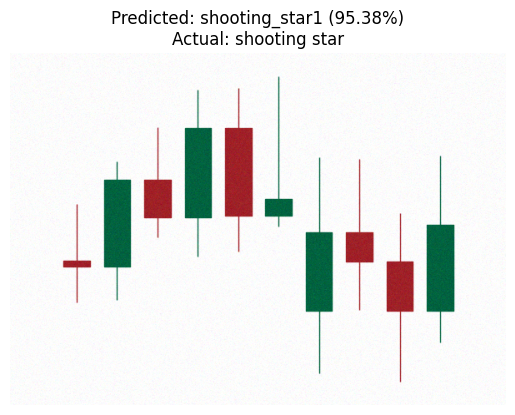

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


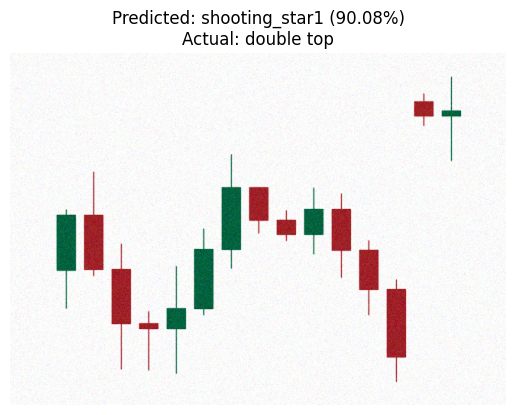

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


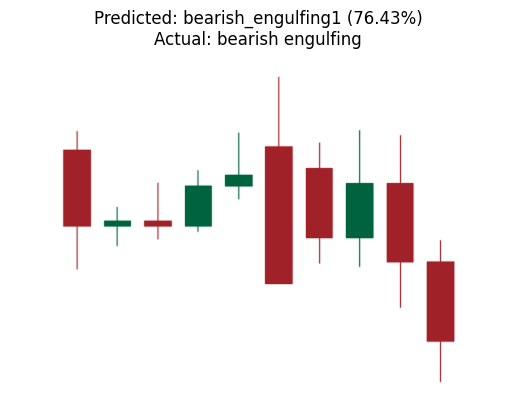

'bearish_engulfing1'

In [ ]:
predict_pattern("/content/candlestick_patterns2/limited_dataset/shooting_star1/shooting_star_0001.png", actual_label="shooting star")

predict_pattern("/content/candlestick_patterns2/limited_dataset/double_top/double_top_0030.png", actual_label="double top")

predict_pattern("/content/candlestick_patterns2/limited_dataset/bearish_engulfing1/bearish_engulfing_0074.png", actual_label="bearish engulfing")


In [ ]:
# Assuming 'model' is your trained Keras model
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc*100:.2f}%")


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 835ms/step - accuracy: 0.8102 - loss: 0.6359
Test Accuracy: 80.00%
